### Home Work 2

#### 1. Introduction

##### 1.1 Load the problem from disk into memory with load_problem

In [1]:
from setup_problem import *
main()

<Figure size 640x480 with 1 Axes>

##### 1.2 input space -> d-dimensional feature space

In [2]:
x_train, y_train, x_val, y_val, target_fn, coefs_true, featurize = load_problem(
                                                                    "lasso_data.pickle")

In [3]:
# 1-d input space
x0 = x_train[0]
x0

0.6665652711501792

In [4]:
X_train = featurize(x_train)
X_val = featurize(x_val)

In [5]:
X_train

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

##### 1.3 Visualize the design matrix

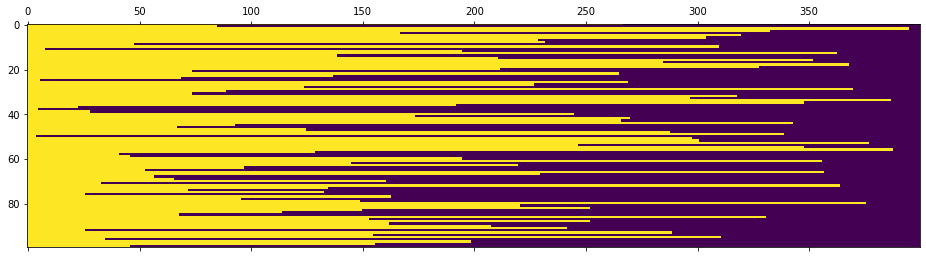

In [6]:
plt.matshow(X_train)

#### 2. Ridge Regression

##### 2.1 Lambda-Empirical risk

In [7]:
from ridge_regression import RidgeRegression

In [8]:
n = X_train.shape[0]
lambdas = np.concatenate((10.**np.arange(-6, 1, 1), np.arange(1, 3, .3)))
avg_square_loss = np.empty(lambdas.shape)

for i, lamb in enumerate(lambdas):
    reg = RidgeRegression(lamb)
    reg.fit(X_train, y_train)
    avg_square_loss[i] = reg.score(X_val, y_val)

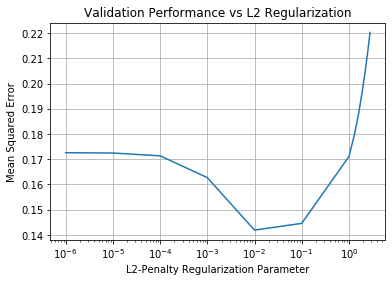

In [9]:
plt.semilogx(lambdas, avg_square_loss)
plt.grid()
plt.title("Validation Performance vs L2 Regularization")
plt.xlabel("L2-Penalty Regularization Parameter")
plt.ylabel("Mean Squared Error")
plt.show()

得到最优的$\lambda^*$为0.01

In [10]:
best_lambda = 0.01

##### Visualize the prediction functions

In [11]:
# 可视化各预测函数
def plot_prediction_functions(x, pred_fns, x_train, y_train,
                              legend_loc="best"):
    # Assumes pred_fns is a list of dicts, and each dict has a "name" key and a
    # "preds" key. The value corresponding to the "preds" key is an array of
    # predictions corresponding to the input vector x. x_train and y_train are
    # the input and output values for the training data
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_xlabel('Input Space: [0,1)')
    ax.set_ylabel('Action/Outcome Space')
    ax.set_title("Prediction Functions")
    plt.scatter(x_train, y_train, label='Training data')
    for i in range(len(pred_fns)):
        ax.plot(x, pred_fns[i]["preds"], label=pred_fns[i]["name"])
    legend = ax.legend(loc=legend_loc, shadow=True)
    return fig

/home/shensir/anaconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


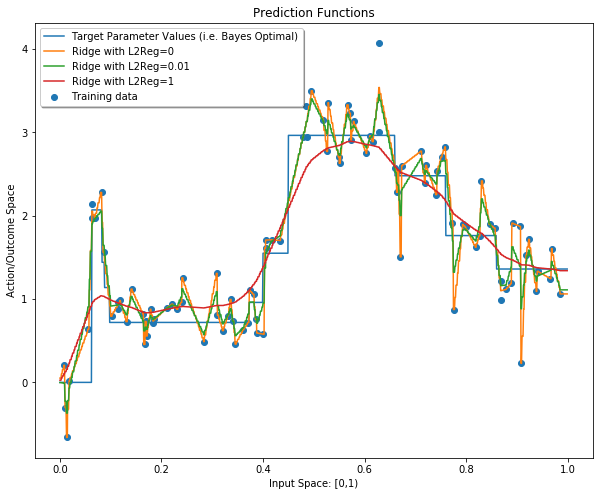

In [12]:
pred_fns = []
x = np.sort(np.concatenate([np.arange(0, 1, .001), x_train]))
name = "Target Parameter Values (i.e. Bayes Optimal)"
pred_fns.append({"name": name, "coefs": coefs_true, "preds": target_fn(x)})

l2regs = [0, best_lambda, 1]
X = featurize(x)
for l2reg in l2regs:
    ridge_regression_estimator = RidgeRegression(l2reg=l2reg)
    ridge_regression_estimator.fit(X_train, y_train)
    name = "Ridge with L2Reg=" + str(l2reg)
    pred_fns.append({
        "name": name,
        "coefs": ridge_regression_estimator.w_,
        "preds": ridge_regression_estimator.predict(X)
    })

f = plot_prediction_functions(x,
                              pred_fns,
                              x_train,
                              y_train,
                              legend_loc="best")
f.show()

/home/shensir/anaconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


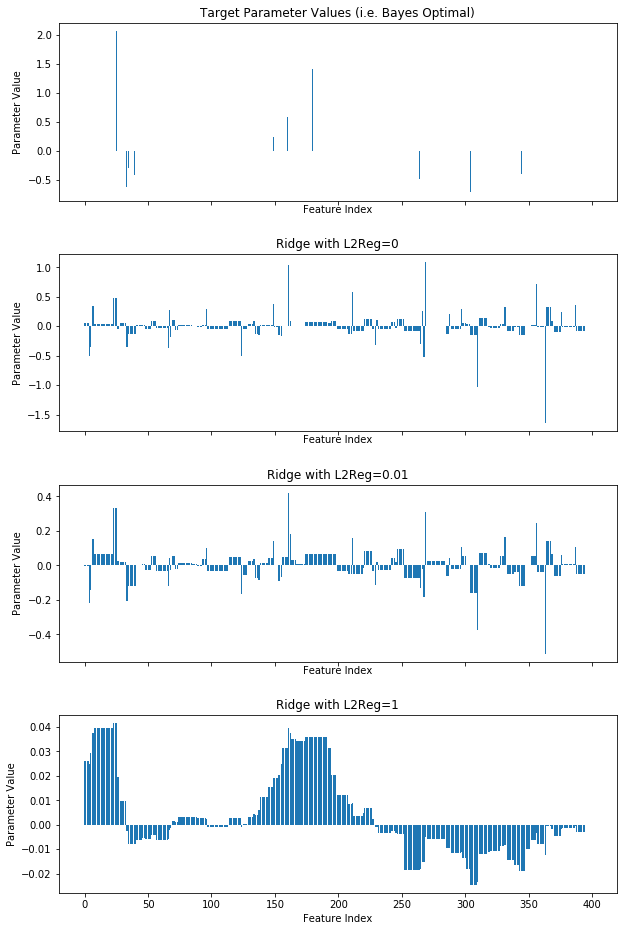

In [13]:
# 各模型参数比较
def compare_parameter_vectors(pred_fns):
    # Assumes pred_fns is a list of dicts, and each dict has a "name" key and a
    # "coefs" key
    fig, axs = plt.subplots(len(pred_fns), 1, sharex=True, figsize=(10, 16))
    num_ftrs = len(pred_fns[0]["coefs"])
    for i in range(len(pred_fns)):
        title = pred_fns[i]["name"]
        coef_vals = pred_fns[i]["coefs"]
        axs[i].bar(range(num_ftrs), coef_vals)
        axs[i].set_xlabel('Feature Index')
        axs[i].set_ylabel('Parameter Value')
        axs[i].set_title(title)

    fig.subplots_adjust(hspace=0.3)
    return fig

f = compare_parameter_vectors(pred_fns)
f.show()

##### 2.3 Confusion matrix

In [14]:
best_pred_fn = pred_fns[2]
best_pred_fn['name']

'Ridge with L2Reg=0.01'

In [15]:
def plot_confusion_matrix(cm, title, classes):
    plt.imshow(cm, interpolation='nearest', cmap = plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,
                 i,
                 format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

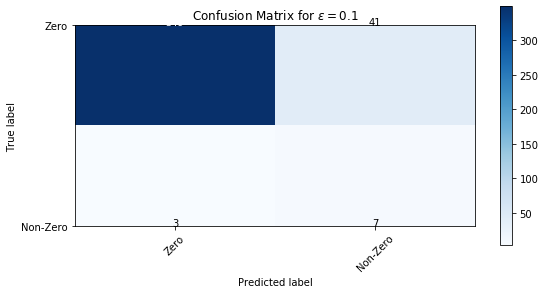

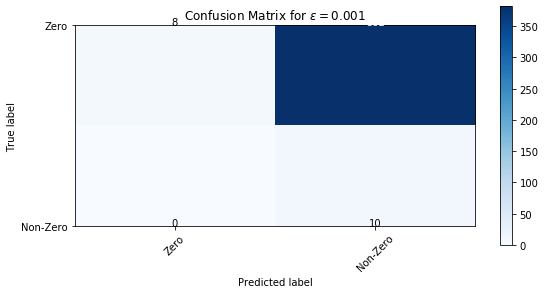

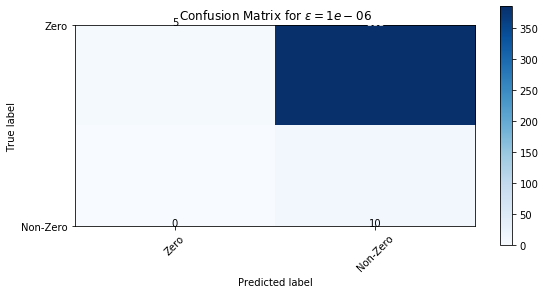

In [16]:
from sklearn.metrics import confusion_matrix
import itertools

epsilons = [1e-1, 1e-3, 1e-6]
for eps in epsilons:
    coefs_eps = [0 if np.abs(coef) < eps else 1 for coef in best_pred_fn['coefs']]
    coefs_true_eps = [0 if np.abs(coef) < eps else 1 for coef in coefs_true]
    cnf_matrix = confusion_matrix(coefs_true_eps, coefs_eps)
    plt.figure(figsize=(8, 4))
    plot_confusion_matrix(
        cnf_matrix,
        title="Confusion Matrix for $\epsilon = {}$".format(eps),
        classes=["Zero", "Non-Zero"])
    plt.show()

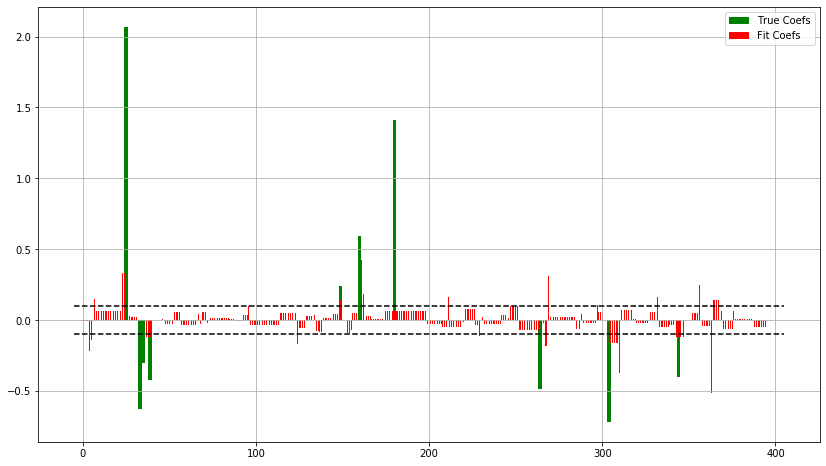

In [17]:
# 我们可以直接将拟合参数和真实参数比较
num_ftrs = len(best_pred_fn['coefs'])
fig, axs = plt.subplots(figsize=(14, 8))
axs.bar(range(num_ftrs), coefs_true, width=2, color='g', label='True Coefs')
axs.bar(range(num_ftrs), best_pred_fn['coefs'], width=0.5, color='r', label='Fit Coefs')
axs.hlines([-0.1, 0.1], xmin=0-5, xmax=num_ftrs+5, linestyle='dashed')
plt.grid()
plt.legend()
plt.show()

#### 3. Coordinate Descent for Lasso(a.k.a The Shooting algorithm)

##### 3.1 Experiments with the Shooting Algorithm

###### 3.1.1 Vectorization

$a_j = 2\sum_{i=1}^n x_{ij}^2 = 2 X_{\cdot j}^T X_{\cdot j}$

$c_j = 2\sum_{i=1}^n x_{ij}(y_i - w^T x_i + w_j x_{ij}) = 2 X_{\cdot j}(y - X w) + 
w_j a_j$

###### 3.1.2 Shooting Algorithm implementation

切记算法在$a_j, c_j$为0时失效，必须进行处理.

In [18]:
# cost function: J(w)
def J(X, y, w, lamb):
    return (X @ w - y).T @ (X @ w - y) + lamb * np.linalg.norm(w, 1)

# soft function
def soft(a, delta):
    return np.sign(a) * max(0, np.abs(a)-delta)

In [19]:
import time
# cyclic coordinate descent
def cyclic_shooting(X, y, lamb = 0.1, max_iter=1000, tolerence=1e-5):
    # initialize w with the ridge regression solution
    I = np.eye(X.shape[1])
    w = np.linalg.inv(X.T @ X + lamb * I) @ X.T @ y
    # iter count
    i = 0
    # init diff in J(w)
    diff = tolerence
    start = time.time()
    while (i < max_iter) and (diff >= tolerence):
        J_old = J(X, y, w, lamb)
        for j in range(X.shape[1]):
            X_j = X[:, j]
            if X_j.sum() == 0:
                w[j] = 0
            else:
                a_j = 2 * X_j.T @ X_j
                c_j = 2 * X_j @ (y - X @ w) + w[j] * a_j
                w[j] = soft(c_j/a_j, lamb/a_j)
        J_new = J(X, y, w, lamb)
        diff = np.abs(J_old - J_new)
        i += 1
    end = time.time()
    print(f"Steps: {i} \n Cost: {J_new} \n Time: {end - start}")
    return w, J_new

In [20]:
w, cost = cyclic_shooting(X_train, y_train)

Steps: 346 
 Cost: 3.9057220920917626 
 Time: 11.275119543075562


In [21]:
# random coordinate descent
def random_shooting(X, y, lamb = 0.1, max_iter=1000, tolerence=1e-5):
    # initialize w with the ridge regression solution
    d = X.shape[1]
    I = np.eye(d)
    w = np.linalg.inv(X.T @ X + lamb * I) @ X.T @ y
    # iter count
    i = 0
    # init diff in J(w)
    diff = tolerence
    start = time.time()
    while (i < max_iter) and (diff >= tolerence):
        J_old = J(X, y, w, lamb)
        for _ in range(d):
            j = np.random.randint(0, d)
            X_j = X[:, j]
            if X_j.sum() == 0:
                w[j] = 0
            else:
                a_j = 2 * X_j.T @ X_j
                c_j = 2 * X_j @ (y - X @ w) + w[j] * a_j
                w[j] = soft(c_j/a_j, lamb/a_j)
        J_new = J(X, y, w, lamb)
        diff = np.abs(J_old - J_new)
        i += 1
    end = time.time()
    print(f"Steps: {i} \n Cost: {J_new} \n Time: {end - start}")
    return w, J_new

In [22]:
w, cost = random_shooting(X_train, y_train)

Steps: 237 
 Cost: 3.907118908380175 
 Time: 6.597401142120361


可以看出随机法略快。

下面进行第二项实验，就是测试初始的`w`设置为`Ridge regression`的解是否加快算法的收敛。

In [23]:
def cyclic_shooting_init_zero(X, y, lamb = 0.1, max_iter=1000, tolerence=1e-5):
    # initialize w with the ridge regression solution
    w = np.zeros((X.shape[1]))
    # iter count
    i = 0
    # init diff in J(w)
    diff = tolerence
    start = time.time()
    while (i < max_iter) and (diff >= tolerence):
        J_old = J(X, y, w, lamb)
        for j in range(X.shape[1]):
            X_j = X[:, j]
            if X_j.sum() == 0:
                w[j] = 0
            else:
                a_j = 2 * X_j.T @ X_j
                c_j = 2 * X_j @ (y - X @ w) + w[j] * a_j
                w[j] = soft(c_j/a_j, lamb/a_j)
        J_new = J(X, y, w, lamb)
        diff = np.abs(J_old - J_new)
        i += 1
    end = time.time()
    print(f"Steps: {i} \n Cost: {J_new} \n Time: {end - start}")
    return w, J_new

In [24]:
w, cost = cyclic_shooting_init_zero(X_train, y_train)

Steps: 565 
 Cost: 3.9057934002162695 
 Time: 13.69455862045288


相比之前的结果，这里多运行了约200次迭代， 慢了大概5秒。可以看出对于`cyclic coordinate descent`， 初始值设为`Ridge regression`的解，使得算法更快的收敛。

In [25]:
def random_shooting_init_zero(X, y, lamb = 0.1, max_iter=1000, tolerence=1e-5):
    # initialize w with the ridge regression solution
    d = X.shape[1]
    I = np.eye(d)
    w = np.zeros((X.shape[1]))
    # iter count
    i = 0
    # init diff in J(w)
    diff = tolerence
    start = time.time()
    while (i < max_iter) and (diff >= tolerence):
        J_old = J(X, y, w, lamb)
        for _ in range(d):
            j = np.random.randint(0, d)
            X_j = X[:, j]
            if X_j.sum() == 0:
                w[j] = 0
            else:
                a_j = 2 * X_j.T @ X_j
                c_j = 2 * X_j @ (y - X @ w) + w[j] * a_j
                w[j] = soft(c_j/a_j, lamb/a_j)
        J_new = J(X, y, w, lamb)
        diff = np.abs(J_old - J_new)
        i += 1
    end = time.time()
    print(f"Steps: {i} \n Cost: {J_new} \n Time: {end - start}")
    return w, J_new

In [26]:
w, cost = random_shooting_init_zero(X_train, y_train)

Steps: 1000 
 Cost: 4.023061213352178 
 Time: 30.24009132385254


相比之前的结果，这里多运行了约300次迭代， 慢了大概20秒。可以看出对于`stochastic coordinate descent`， 初始值设为`Ridge regression`的解，使得算法更快的收敛。

###### 3.1.3 Choose the best model

In [48]:
# choose best lambda
lambdas = np.arange(0.1, 3.1, 0.3)
square_errors = []
for lamb in lambdas:
    w, cost = cyclic_shooting(X_train, y_train, lamb)
    n_val = X_val.shape[0]
    diff = y_val - X_val @ w
    error = (1/n_val)* (diff.T @ diff)
    square_errors.append(error)

Steps: 346 
 Cost: 3.9057220920917626 
 Time: 10.899976253509521
Steps: 364 
 Cost: 9.999806768722944 
 Time: 11.935298442840576
Steps: 351 
 Cost: 13.69789987437533 
 Time: 10.656366109848022
Steps: 238 
 Cost: 16.198493848668683 
 Time: 7.161871433258057
Steps: 234 
 Cost: 18.209415500586278 
 Time: 6.994313478469849
Steps: 222 
 Cost: 20.14701753909923 
 Time: 6.510580539703369
Steps: 215 
 Cost: 22.01670227363669 
 Time: 6.27747106552124
Steps: 205 
 Cost: 23.818798236041197 
 Time: 6.1040284633636475
Steps: 199 
 Cost: 25.55974718872147 
 Time: 5.98985743522644
Steps: 197 
 Cost: 27.243274752137907 
 Time: 5.89511775970459


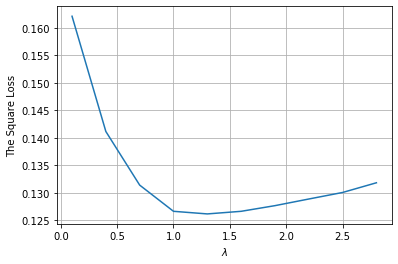

In [49]:
plt.plot(lambdas, square_errors)
plt.xlabel("$\lambda$")
plt.ylabel("The Square Loss")
plt.grid()
plt.show()

可以看出，最优的$\lambda$为1.3

In [53]:
best_l1Reg = 1.3

In [50]:
w_best, cost = cyclic_shooting(X_train, y_train, best_l1Reg)

Steps: 234 
 Cost: 18.209415500586275 
 Time: 9.03470230102539


In [43]:
# plot it
pred_fns[1]['name'] = 'Lasso with L1Reg=1.3'
pred_fns[1]['coefs'] = w_best
pred_fns[1]['preds'] = X @ w_best

/home/shensir/anaconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


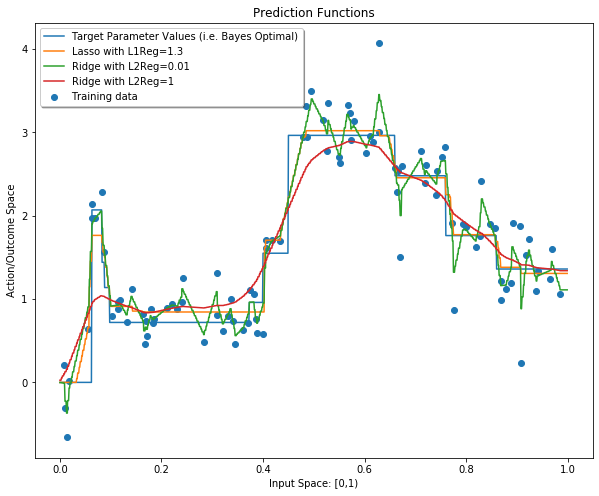

In [44]:
f = plot_prediction_functions(x,
                              pred_fns,
                              x_train,
                              y_train,
                              legend_loc="best")
f.show()

/home/shensir/anaconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


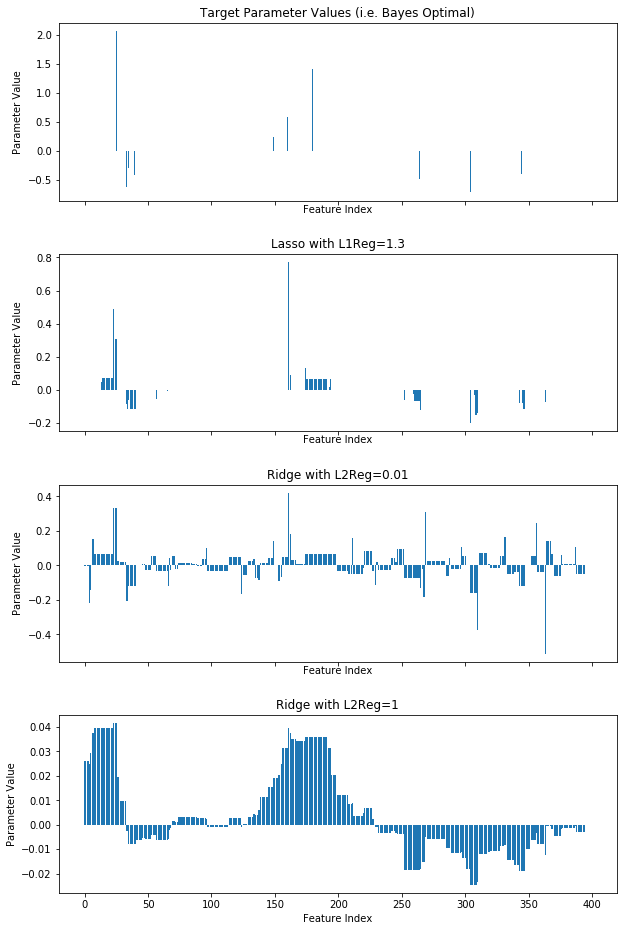

In [45]:
# parameters
f = compare_parameter_vectors(pred_fns)
f.show()

可以明显地看到Lasso回归参数的稀疏性质。

下面综合以上讨论，找出最优的模型。

首先是之前的Ridge Regression.

In [46]:
reg = RidgeRegression(best_lambda)
reg.fit(X_train, y_train)
ridge_loss = reg.score(X_val, y_val)
print(f"Loss of Ridge Regression: {ridge_loss}")

Loss of Ridge Regression: 0.1418868289702678


之后是我们的Lasso Regression.

In [52]:
n_val = X_val.shape[0]
diff = y_val - X_val @ w_best
lasso_error = (1/n_val)* (diff.T @ diff)
print(f"Loss of Lasso Regression: {lasso_error}")

Loss of Lasso Regression: 0.1261804071132777


比较可以看出Lasso Regression的效果要略好一点。最后的模型参数为`w_best`（此时的`l1Reg`为1.3）

In [54]:
w_best

array([-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  4.55948596e-02,  6.78915834e-02,  6.78915834e-02,
        6.78915834e-02,  6.78915834e-02,  6.78915834e-02,  6.78915834e-02,
        6.78915834e-02,  6.78915834e-02,  6.78915834e-02,  4.90472551e-01,
        3.08461331e-01,  3.08461331e-01,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -8.56958870e-02, -1.14248596e-01, -6.40034853e-02,
       -1.17625670e-01, -1.17625670e-01, -1.17625670e-01, -1.17625670e-01,
       -1.17625670e-01, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -

###### 3.1.4 Homotopy method

In [56]:
lambda_max = 2 * np.linalg.norm(X_train.T @ y_train, np.inf)
lambda_max

327.28283232952117

In [70]:
lambdas = [lambda_max*0.8**i for i in range(40)]
square_errors = []
for lamb in lambdas:
    w, cost = cyclic_shooting(X_train, y_train, lamb)
    n_val = X_val.shape[0]
    diff = y_val - X_val @ w
    error = (1/n_val)* (diff.T @ diff)
    square_errors.append(error)

Steps: 2 
 Cost: 359.66740028131966 
 Time: 0.1015324592590332
Steps: 262 
 Cost: 348.52155437217954 
 Time: 9.774232864379883
Steps: 321 
 Cost: 323.53763737412146 
 Time: 10.258463144302368
Steps: 280 
 Cost: 293.2295833705647 
 Time: 8.744167804718018
Steps: 260 
 Cost: 262.2367027456721 
 Time: 8.198684692382812
Steps: 231 
 Cost: 231.30405297297716 
 Time: 7.697720527648926
Steps: 221 
 Cost: 202.01790812697152 
 Time: 6.706825494766235
Steps: 212 
 Cost: 175.6833918002793 
 Time: 6.436984062194824
Steps: 209 
 Cost: 152.73993157352896 
 Time: 6.148192405700684
Steps: 202 
 Cost: 133.12910902119603 
 Time: 7.134052753448486
Steps: 181 
 Cost: 116.62140481981228 
 Time: 8.101659774780273
Steps: 177 
 Cost: 102.89105529835007 
 Time: 5.601730585098267
Steps: 167 
 Cost: 91.40183772174707 
 Time: 4.963954210281372
Steps: 151 
 Cost: 80.59549922928113 
 Time: 5.767557144165039
Steps: 147 
 Cost: 70.65160757124072 
 Time: 4.952700853347778
Steps: 166 
 Cost: 61.83949577155356 
 Time: 5

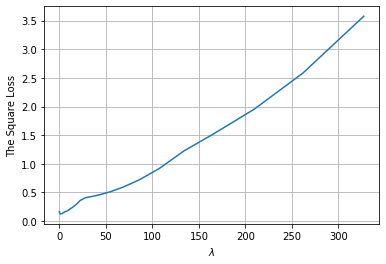

In [78]:
plt.plot(lambdas, square_errors)
plt.xlabel("$\lambda$")
plt.ylabel("The Square Loss")
plt.grid()
plt.show()